## Deep learning model

This is an alternative version of the replay buffer

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Code of the DQN agent.

Inspired from here: https://medium.com/@hkabhi916/mastering-deep-q-learning-with-pytorch-a-comprehensive-guide-a7e690d644fc

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from kaggle_environments import make, evaluate
import random

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
TAU = 0.005
LR = 1e-4


class DQN(nn.Module):
    def __init__(self, insize, action_space):
        super().__init__()
        self.input = nn.Linear(insize, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, action_space)

    def forward(self, x):
        #x = tc.tanh(self.input(x))
        x = F.relu(self.input(x))
        #x = tc.tanh(self.layer1(x))
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x


class DeepQLearner:
    """The trainer, to be serialised"""

    def __init__(self, config, discount=0.99, learning_rate=0.001):

        print(f"Creating agent with {config}")
        self.square_options = 3  # empty, player 1, player2

        # hyperparameters
        self.learning_rate = learning_rate
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.discount = discount
        self.batch_size = BATCH_SIZE

        self.memory = deque(maxlen=10000)

        self.action_range = config.columns
        # E.g. for board states rows*cols that can be in position 0, 1, 2
        self.state_len = config.rows * config.columns

        self.model = DQN(self.state_len, self.action_range)
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate)

    def act(self, board):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_range)
        state_tensor = torch.as_tensor(board, dtype=torch.float)
        action_predictions = self.model(state_tensor)
        return torch.argmax(action_predictions).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_rewards = torch.max(self.model(torch.tensor(next_state, dtype=torch.float32))).item()
                #print(f"Next rewards: {next_rewards}")
                target = reward + self.discount * next_rewards
            target_f = self.model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
            target_f[action] = target  # WHY? because we know the reward for this selected action, so we put it in the y (target/label)
            self.optimizer.zero_grad()
            loss = self.loss_function(torch.tensor(target_f), self.model(torch.tensor(state, dtype=torch.float32)))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > EPS_END:
            self.epsilon *= self.epsilon_decay

    def save(self, filename="model.pt"):
        print(f"Saving {filename} (whole model, includes file path)")
        torch.save(self.model, filename)

    def save_state_dict(self, filename="model_state_dict.pt"):
        print(f"Saving {filename} (state dict only)")
        torch.save(self.model.state_dict(), filename)

    def load(self, filename="model.pt"):
        print(f"Loading {filename}")
        self.model = torch.load(filename)

    def load_from_state_dict(self, filename="model_state_dict.pt"):
        print(f"Loading model from state dict {filename}")
        self.model = FFDNN(self.state_len, self.action_range)
        state_dict = torch.load(filename)
        self.model.load_state_dict(state_dict)
        self.model.eval()

termcolor not installed, skipping dependency
No pygame installed, ignoring import


Functions for custom reward

In [2]:
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

def get_heuristic(grid, mark, config):
    score = 0
    for i in range(config.inarow):
        num = count_windows(grid, i+1, mark, config)
        if (i==(config.inarow-1) and num>=1):
            return 2**(config.inarow+3)
        score += 2**(i+1) * num
        num_opp = count_windows(grid, i+1, mark%2+1, config)
        if (i==(config.inarow-1) and num_opp>=1):
            return -2**(2*(config.inarow+3))
        score -= 2**(2*(i+1)) * num_opp
    return score

Training the agent

In [6]:
from matplotlib import pyplot as plt

# Initialize environment and agent with Experience Replay Buffer
env = make("connectx", debug=True)

agent = DeepQLearner(env.configuration)

# Training agent in first position (player 1) against the default random agent.
trainer = env.train([None, "negamax"])

obs = trainer.reset()
print(f"Obs: {obs}")
mark = obs.mark

# Train the DQN agent with Experience Replay Buffer
batch_size = 64
num_episodes = 5000
wins = 0
invalids = 0
rewards = []
for episode in range(num_episodes):
    done = False
    total_reward = 0
    #env.render()
    while not done:
        #print(f"Obs: {obs}")
        # print(f"Board: {board}")
        action = agent.act(obs.board)
        #print(f"Action: {action}")
        next_obs, reward, done, _ = trainer.step(action)
        #print(f"Original reward: {reward}")
        #print(f"Next obs: {next_obs}")

        if done and reward is not None and reward>0:
            #print("WIN!")
            wins += 1
            reward = 100000
            
        # invalid action
        elif reward is None:
            #print("REWARD FOR INVALID ACTION")
            invalids += 1
            reward = -100000
            # new_action_range = [i for i in range(0, env.configuration.columns) if i!=action]
            # action = random.choice(new_action_range)

        # custom reward
        else:
            grid = np.asarray(obs.board).reshape(env.configuration.rows, env.configuration.columns)
            # invalid action
            if grid[0][action] != 0:
                reward = -2**(2*(env.configuration.inarow+3))
                print("IT SHOULD NOT ENTER HERE")
            else:
                reward = get_heuristic(drop_piece(grid, action, mark, env.configuration), mark, env.configuration)
        
        agent.remember(obs.board, action, reward, next_obs.board, done)
        obs = next_obs
        total_reward += reward
        agent.replay(batch_size)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
    rewards.append(total_reward)
    obs = trainer.reset()
#print(f"History of episode reward: {rewards}")
#plt.plot(rewards)
#plt.show()
print(f"Episodes won: {wins}, percentage: {wins/num_episodes}")
print(f"Invalid actions: {invalids}, percentage: {invalids/num_episodes}")
agent.save()

Creating agent with {'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'columns': 7, 'rows': 6, 'inarow': 4, 'agentTimeout': 60, 'timeout': 2}
Obs: {'remainingOverageTime': 60, 'step': 0, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mark': 1}
Episode: 1, Total Reward: -98
Invalid Action: Invalid column: 2
Episode: 2, Total Reward: -100116
Episode: 3, Total Reward: -268
Episode: 4, Total Reward: -506
Episode: 5, Total Reward: -84
Episode: 6, Total Reward: -204
Episode: 7, Total Reward: -164
Invalid Action: Invalid column: 3
Episode: 8, Total Reward: -99960
Invalid Action: Invalid column: 6
Episode: 9, Total Reward: -100042
Episode: 10, Total Reward: -106
Episode: 11, Total Reward: -34
Invalid Action: Invalid column: 0
Episode: 12, Total Reward: -100044
Episode: 13, Total Reward: -80
Episode: 14, Total Reward: -200
Invalid Action: Invalid column: 5
Episode: 15, Total Reward: -100032
Epis

### Training results

|Number of episodes|Won (percentage)|Invalid actions (percentage)|
|---|---|---|
|1000|671 (0.671)|281 (0.281)|
|2000|1496 (0.748)|148 (0.074)|
|3000|2331 (0.777)|310 (0.103)|81

In [8]:
agent.epsilon
len(agent.memory)

10000

In [13]:
def my_agent(env, config):
    agent = DeepQLearner(config)
    agent.load()
    return agent.act(obs.board)

Below is a copy for debug

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import kaggle_environments as ke
from utils.env_wrapper import ConnectX

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


class DQN(nn.Module):
    def __init__(self, insize, action_space):
        super().__init__()
        self.input = nn.Linear(insize, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, action_space)

    def forward(self, x):
        #x = tc.tanh(self.input(x))
        x = F.relu(self.input(x))
        #x = tc.tanh(self.layer1(x))
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x


class DeepQLearner:
    """The trainer, to be serialised"""

    def __init__(self, config, discount=0.9, learning_rate=1.0):

        print(f"Creating agent with {config}")
        self.square_options = 3  # empty, player 1, player2

        # hyperparameters
        self.learning_rate = learning_rate
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.discount = discount
        self.batch_size = BATCH_SIZE

        self.memory = deque(maxlen=10000)

        self.action_range = config.columns
        # E.g. for board states rows*cols that can be in position 0, 1, 2
        self.state_len = config.rows * config.columns

        self.model = DQN(self.state_len, self.action_range)
        self.loss_function = nn.MSELoss()
        self.optimizer = tc.optim.Adam(
            self.model.parameters(), lr=self.learning_rate)

    def act(self, board):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_range)
        state_tensor = torch.as_tensor(board, dtype=torch.float)
        action_predictions = self.model(state_tensor)
        return tc.argmax(action_predictions).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(torch.tensor(next_state, dtype=torch.float32))).item()
            target_f = self.model(torch.tensor(state, dtype=torch.float32)).numpy()
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = self.loss_function(torch.tensor(target_f), self.model(torch.tensor(state, dtype=torch.float32)))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay

    def do_training_episode(self, render=True):
        trainer = self.connectx.env.train([None, "random"])
        obs = trainer.reset()

        rewards = []
        while not self.connectx.env.done:
            state_tensor = tc.as_tensor(np.expand_dims(obs.board, 0), dtype=tc.float)
            action_predictions = self.model(state_tensor)

            # Remove values where the max value is a full column by min,
            # -1. so that if empty column has min value, it is still picked
            less_than_min_value = tc.min(action_predictions) - 1.
            non_full_columns = tc.where(
                tc.tensor(  # where col is not full
                    obs.board[:self.connectx.configuration["columns"]]) == 0,
                action_predictions,
                less_than_min_value  # avoid selection if col is full
            )

            if not self.connectx.env.done:
                action = tc.argmax(non_full_columns, dim=-1)
                next_obs, reward, done, info = trainer.step(int(action))
                rewards.append(reward)
                # if render:
                #     env.render(mode="ipython", width=100, height=90, header=False, controls=False)
                self.update(
                    tc.as_tensor(np.expand_dims(obs.board, 0), dtype=tc.float),
                    action, reward, 
                    tc.as_tensor(np.expand_dims(next_obs.board, 0), dtype=tc.float))
            obs = next_obs

        if render:
            env.render()  # final state

        return rewards

    def update(self, s, a, r, nxt_s):
        """Update the model with Bellman equation
        
        TODO: introduce if done, 0?
        """

        # Create the "label"
        q_prediction = tc.max(self.model(nxt_s), dim=-1)[0]  # max (1 is index)
        target_q = r + self.discount * q_prediction

        # Create the "predicted value" - at action a
        q_preds_from_state = self.model(s)
        gather_indices = tc.arange(a.shape[0]) * q_preds_from_state.shape[-1] + a
        q_preds_from_state_at_a = tc.gather(
            tc.reshape(q_preds_from_state, [-1]),
            -1,
            gather_indices
        )

        loss = tc.mean(self.loss_function(target_q, q_preds_from_state_at_a))
        loss.backward()
        self.optimizer.step()

        return loss  # todo - VALUE?

    def save(self, filename="model.pt"):

        print(f"Saving {filename} (whole model, includes file path)")
        tc.save(self.model, filename)

    def save_state_dict(self, filename="model_state_dict.pt"):
        print(f"Saving {filename} (state dict only)")
        tc.save(self.model.state_dict(), filename)

    def load(self, filename="model.pt"):

        print(f"Loading {filename}")
        self.model = tc.load(filename)

    def load_from_state_dict(self, filename="model_state_dict.pt"):
        print(f"Loading model from state dict {filename}")
        self.model = FFDNN(self.state_len, self.action_range)
        state_dict = tc.load(filename)
        self.model.load_state_dict(state_dict)
        self.model.eval()


if __name__ == "__main__":

    # View init
    env = ConnectX()  # , {"rows": 4, "columns": 4}, debug=True)
    env.render()
    agent = DeepQLearner(env)

    model_name = "model10k.pt"
    state_dict_name = "model_state_dict10k.pt"
    
    # Train, player 1 against random
    if not os.path.exists(model_name):
        print("Train agent")
        for i in range(10000):
            if i % 100 == 0:
                print("Trained", i)
            agent.do_training_episode(render=False)
        agent.save(model_name)
        agent.save_state_dict(state_dict_name)
    else:
        # safer, doesn't require file reference
        agent.load_from_state_dict(state_dict_name)

In [2]:
def get_heuristic(grid, mark, config):
    score = 0
    for i in range(config.inarow):
        num = count_windows(grid, i+1, mark, config)
        score += (4**(i+1))*num
        num_opp = count_windows(grid, i+1, mark%2+1, config)
        score -= (2**((2*i)+3))*num_opp
    return score

We will take each window of 4 on the board and use it to evaluate a score.

In [17]:
def get_heuristic(grid, mark, config):
    score = 0
    for i in range(config.inarow):
        num = count_windows(grid, i+1, mark, config)
        if (i==(config.inarow-1) and num>=1):
            return float("inf")
        score += 2**(i+1) * num
        num_opp = count_windows(grid, i+1, mark%2+1, config)
        if (i==(config.inarow-1) and num_opp>=1):
            return float("-inf")
        score -= 2**(2*(i+1)) * num_opp
    return score

# Defining the rest of the functions 

Nothing much to explain here. Most of the functions are the same as compared to the tutorial notebook.

In [3]:
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

# Implementing minimax

Here we have used 2 functions score_move_a and score_move_b that are calling each other recursively.

In [4]:
def score_move_a(grid, col, mark, config,n_steps=1):
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    if len(valid_moves)==0 or n_steps ==0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else :
        scores = [score_move_b(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = min(scores)
    return score

def score_move_b(grid, col, mark, config,n_steps):
    next_grid = drop_piece(grid,col,(mark%2)+1,config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    if len(valid_moves)==0 or n_steps ==0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else :
        scores = [score_move_a(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = max(scores)
    return score

# Defining the agent.

Here we have implemented a 1 step look-ahead agent. 

In [5]:
def agent(obs, config):
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid, col, obs.mark, config,1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

## Testing the agent against negamax

In [6]:
from kaggle_environments import make, evaluate

termcolor not installed, skipping dependency
No pygame installed, ignoring import


In [17]:
env = make("connectx", debug=True)
env.run([my_agent,"negamax"])
env.render(mode="ipython")

Creating agent with {'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'columns': 7, 'rows': 6, 'inarow': 4, 'agentTimeout': 60, 'timeout': 2}
Loading model.pt
C:\Users\shago\AppData\Local\Temp\ipykernel_15624\345777383.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full cont

## Getting win percentage

Since one iteration is not enough to conclude which agent is better we run 100 iterations.

In [8]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    config = {'rows': 10, 'columns': 7, 'inarow': 4}
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [16]:
get_win_percentages(agent1=agent, agent2="negamax",n_rounds = 100)

Agent 1 Win Percentage: 0.92
Agent 2 Win Percentage: 0.04
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


Now the algorithm works good and does get a good score but the question is how can we do better? 

So the thing is There are two main problems with the algorithm.

1. The first one is fairly obvious that the this version of minimax is not efficient and could do better with optimisations like alpha-beta pruning.

2. The second problem is a bit more subtle and complex. If you carefully understand what minimax is doing, it computes the score for each permutation possible but the agent will often come across a case when both players can win if they make a move and it is your agents turn as shown below. 

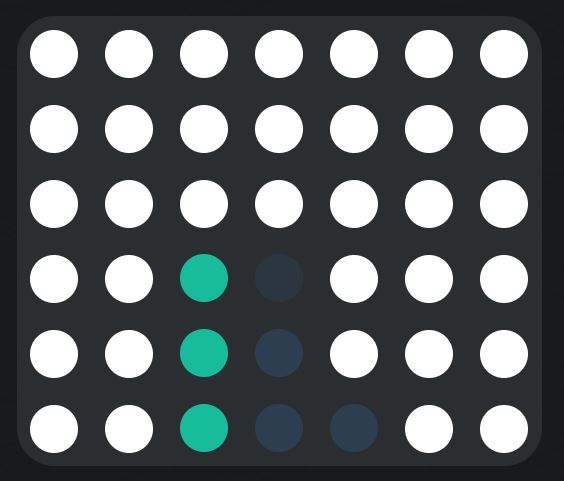

If you are playing with color green you can win this turn by playing in column 3(1 based indexing) but the agent will not play in this column rather in column 4. This is because when it computes the score, he sees that after he makes a 4 in a row the opponent also makes a 4 in a row and since it adds a higher penalty, the agent tries to stop the other one raher than making his own because the agent does not understand the concept that the game ends as soon as he makes a 4 in a row. First we will try to address the first problem by making minor tweaks to the functions.

# Improved agent

First we shall tweak the heuristic function to return a score of infinity whenever we get a 4 in a row and a score of -infinity if the opponent gets a 4 in a row.

## Tweaking the hueristic

In [10]:
def get_heuristic(grid, mark, config):
    score = 0
    for i in range(config.inarow):
        num  = count_windows (grid,i+1,mark,config)
        if (i==(config.inarow-1) and num >= 1):
            return float("inf")
        score += (4**(i+1))*num
    for i in range(config.inarow):
        num_opp = count_windows (grid,i+1,mark%2+1,config)
        if (i==(config.inarow-1) and num_opp >= 1):
            return float ("-inf")
        score-= (2**((2*i)+3))*num_opp
    return score

## Tweaking the minimax functions

In [11]:
def score_move_a(grid, col, mark, config,n_steps=1):
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    score = get_heuristic(next_grid, mark, config)
    #Since we have just dropped our piece there is only the possibility of us getting 4 in a row and not the opponent.
    #Thus score can only be +infinity.
    if len(valid_moves)==0 or n_steps ==0 or score == float("inf"):
        return score
    else :
        scores = [score_move_b(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = min(scores)
    return score

def score_move_b(grid, col, mark, config,n_steps):
    next_grid = drop_piece(grid,col,(mark%2)+1,config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    score = get_heuristic(next_grid, mark, config)
    #The converse is true here.
    #Since we have just dropped opponent piece there is only the possibility of opponent getting 4 in a row and not us.
    #Thus score can only be -infinity.
    if len(valid_moves)==0 or n_steps ==0 or score == float ("-inf"):
        return score
    else :
        scores = [score_move_a(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = max(scores)
    return score

## Defining the agent with new functions

In [12]:
def agent(obs, config):
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid, col, obs.mark, config,1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

By doing these few tweaks the function will return the score of infinity as soon as it selects a row that makes a four in a row thus making the score higher than could be obtained any other way.

This also ensures that if by us making a move enables the opponent to make a four in a row, a score of -infinity is returned and that path in the minimax tree is thrown out and the agent gives any other path a priority if it returns a non -infinity score without condsidering how low the score is.

## Testing against negamax

In [9]:
env = make("connectx", debug=True)
env.run([agent,"negamax"])
env.render(mode="ipython")

Invalid Action: <__main__.DeepQLearner object at 0x000001EE5DF164B0> is not of type 'integer'

Failed validating 'type' in schema:
    {'default': 0,
     'description': 'Column to drop a checker onto the board.',
     'minimum': 0,
     'type': 'integer'}

On instance:


## Obtaining the win percentage

In [14]:
get_win_percentages(agent1=agent, agent2="negamax",n_rounds = 100)

Agent 1 Win Percentage: 0.96
Agent 2 Win Percentage: 0.03
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


## Optimising the agent

Now this agent seems to work good but here is alot of room for optimisation so that agent works faster. In order to do so we need to understand the complexity of the algorithm and where it could be reduced.

### Understanding the complexity for a one step lookahead:

For one step lookahead the following steps are to be performed:

P.S: Here we have considered a board size on n*n and m pieces to connect
1. The program drops a piece in each of the n columns which takes O(n^2) and generates n configurations

2. For each of the n columns, it agains drops opponent piece in each possible column O(n^3) and genrates n^2 configurations

3. For each of these n^2 cofigurations, a heuristic function is called upon. This heuritic function calls count_windows for each value less than config.inarow resulting in (n^2)*m configuraions

4. The count_windows isolates all possible windows of size config.inarow in the grid resulting in (n^2)* m * ((n-m+1)^2) which we can take as (n^4)*m for simplicity

5. Now for each of these windows a check_window is called once resulting in the total complexity to be (n^4)*(m^2)

6. The complexity of check window itself is m and therfore the final complexity is of the order (n^4)*(m^2)

Now the question is where can we reduce the time taken? The answer is at step 3.

The insight is instead of calling check_window for each value less than m, we can use check window to return the correct count of m that it would have returned true for in the same time by cheking that if number of opponent piece are 0 then we can easily return the count of our piece. This will reduce our complexity to (n^4)*(m) which might not seem a lot but consider this that if the value of m was 4, the new code would be 4 times fater than the old one. A computation that earlier took 12 seconds and would have resulted in invalid submission can now be submitted and will run easily.

The code for the following optimisation is given below


### Tweaking the functions

In [15]:
def get_heuristic(grid, mark, config):
    score = 0
    num = count_windows(grid,mark,config)
    for i in range(config.inarow):
        if (i==(config.inarow-1) and num[i+1] >= 1):
            return float("inf")
        score += (4**(i))*num[i+1]
    num_opp = count_windows (grid,mark%2+1,config)
    for i in range(config.inarow):
        if (i==(config.inarow-1) and num_opp[i+1] >= 1):
            return float ("-inf")
        score-= (2**((2*i)+1))*num_opp[i+1]
    return score

def check_window(window, piece, config):
    if window.count((piece%2)+1)==0:
        return window.count(piece)
    else:
        return -1

def count_windows(grid, piece, config):
    num_windows = np.zeros(config.inarow+1)
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            type_window = check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            type_window = check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            type_window = check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            type_window = check_window(window, piece, config)
            if type_window != -1:
                num_windows[type_window] += 1
    return num_windows

def check_window(window, piece, config):
    if window.count((piece%2)+1)==0:
        return window.count(piece)
    else:
        return -1

In [10]:
env = make("connectx", debug=True)
env.run([agent,"negamax"])
env.render(mode="ipython")

Invalid Action: <__main__.DeepQLearner object at 0x000001EE5DF31640> is not of type 'integer'

Failed validating 'type' in schema:
    {'default': 0,
     'description': 'Column to drop a checker onto the board.',
     'minimum': 0,
     'type': 'integer'}

On instance:


In [17]:
get_win_percentages(agent1=agent, agent2="negamax",n_rounds = 100)

Agent 1 Win Percentage: 0.94
Agent 2 Win Percentage: 0.04
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


**Please upvote if you liked my work. I have tried to make this as intuitive as possible. Any suggestions are welcome. Thank You!!**